In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

##### Code Snippets from Mike X Cohen, sincxpress.com class on Udemy.com

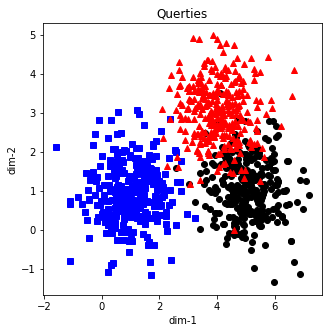

In [2]:
# Create Data: 3 classes

nPerCluster = 300
blur = 0.8
A = [1, 1] # Centroid
B = [5, 1]
C = [4, 3]

a = [ A[0]+np.random.randn(nPerCluster)*blur, A[1]+np.random.randn(nPerCluster)*blur ]
b = [ B[0]+np.random.randn(nPerCluster)*blur, B[1]+np.random.randn(nPerCluster)*blur ]
c = [ C[0]+np.random.randn(nPerCluster)*blur, C[1]+np.random.randn(nPerCluster)*blur ]

labels_np = np.hstack((np.zeros((nPerCluster)),np.ones((nPerCluster)), 1+np.ones((nPerCluster)) ))
data_np = np.hstack((a,b,c)).T  # matrix concatenation

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], "bs")
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], "ko")
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1], "r^")
plt.title("Querties")
plt.xlabel("dim-1")
plt.ylabel("dim-2")
plt.show()

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

In [4]:
batchsize=16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

print(f"There are {len(train_loader)} train data batches, each with {batchsize} samples")

There are 45 train data batches, each with 16 samples


In [5]:
def createModel(optimizerAlgo, learningrate):
    
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(2,8)
            self.fc1 = nn.Linear(8,8)
            self.output = nn.Linear(8,3)
        
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)
        
    model = Model()
    lossfun = nn.CrossEntropyLoss()
    optimfun = getattr(torch.optim, optimizerAlgo)
    optimizer = optimfun(model.parameters(), lr=learningrate)
    return model,lossfun,optimizer


def trainModel(learningrate, optimizerType: str, numEpochs: int=50):
    model,lossfun,optimizer = createModel(optimizerType, learningrate)
    losses = torch.zeros(numEpochs)
    trainAcc = []
    testAcc = []
    
    #loop over Epochs
    for epochi in tqdm(range(numEpochs)):
        model.train()
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            yHat = model(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            matches = torch.argmax(yHat, axis=1)==y
            numericMatches = matches.float()
            accuracyPct = 100*torch.mean(numericMatches)
            batchAcc.append(accuracyPct)
        #end of batch
        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)
        
        #test Accuracy
        model.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = model(X)
        testAcc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()))
    #end of epochs
    return trainAcc,testAcc,losses,model
        
    
            

In [6]:
## Test parametric optimizer for model creation: SGD, RMSprop, Adam
optim = createModel("Adam", 0.01)[2]
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [7]:
def plotResults(optimizerType:str):
    yHat = model(data)
    predictions = torch.argmax(yHat, axis=1)
    accuracy = (predictions == labels).float()
    totalAcc = torch.mean(100*accuracy).item()
    
    accuracyByCategory = np.zeros(3)
    for i in range(3):
        accuracyByCategory[i] = 100*torch.mean(accuracy[labels==i])
    
    fig,ax = plt.subplots(2,2, figsize=(18,9))
    ax[0,0].plot(losses.detach())
    ax[0,0].set_ylabel("Loss")
    ax[0,0].set_xlabel("Epochs")
    ax[0,0].set_title(f"{optimizerType}: losses")
    
    ax[0,1].plot(trainAcc, label="Train")
    ax[0,1].plot(testAcc, label="Test")
    ax[0,1].set_ylabel("Accuracy %")
    ax[0,1].set_xlabel("Epochs")
    ax[0,1].set_title(f"{optimizerType}: Accuracy")
    ax[0,1].legend()
    
    ax[1,0].bar(range(3), accuracyByCategory)
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_ylim([np.min(accuracyByCategory)-5, np.max(accuracyByCategory)+5])
    ax[1,0].set_ylabel("Accuracy %")
    ax[1,0].set_xlabel("Optimizer Group")
    ax[1,0].set_title(f"{optimizerType}: Accuracy by Group")
    
    colorShapes = ["bs", "ko", "g^"]
    for i in range(3):
        ax[1,1].plot(data[labels==i,0], data[labels==i, 1], colorShapes[i], alpha=0.3, label = f"Label-Category {i}")
        idxErr = (accuracy==0) & (labels==i)
        ax[1,1].plot(data[idxErr, 0], data[idxErr, 1], "rx")
    
    ax[1,1].set_title(f"{optimizerType}: total accuracy: {totalAcc:.2f}%")
    ax[1,1].set_xlabel("dim1")
    ax[1,1].set_ylabel("dim2")
    ax[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.71it/s]


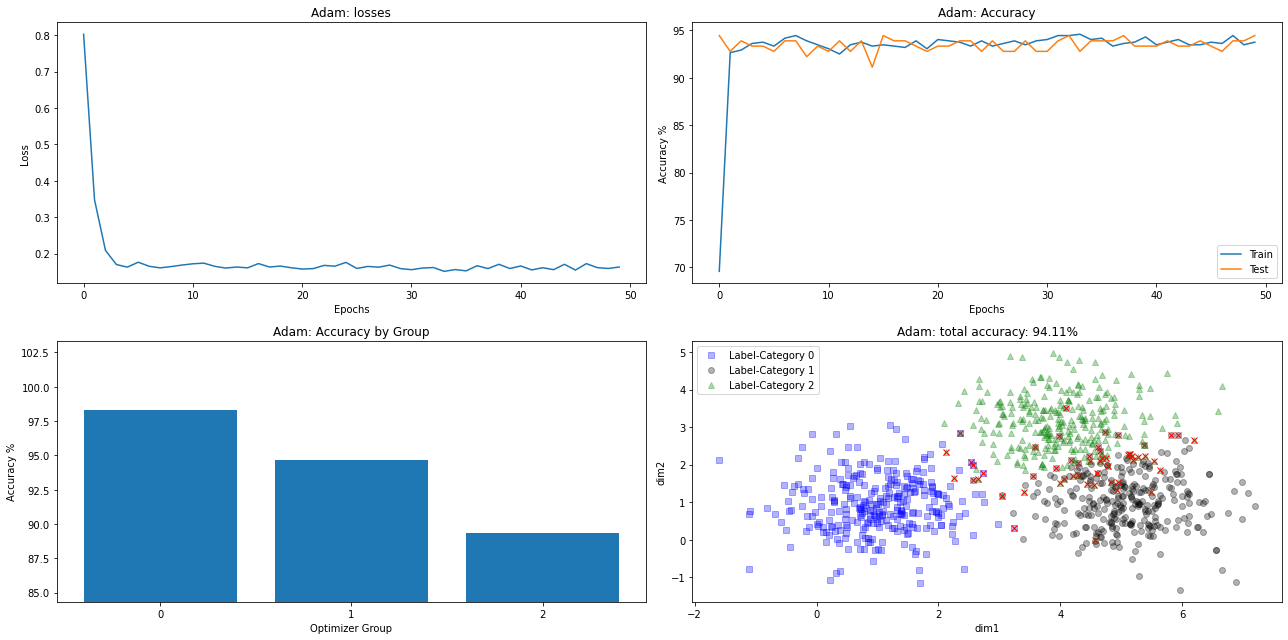

In [9]:
optimizerType = "Adam"
trainAcc,testAcc,losses,model = trainModel(0.01, optimizerType, 50)
plotResults(optimizerType)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.52it/s]


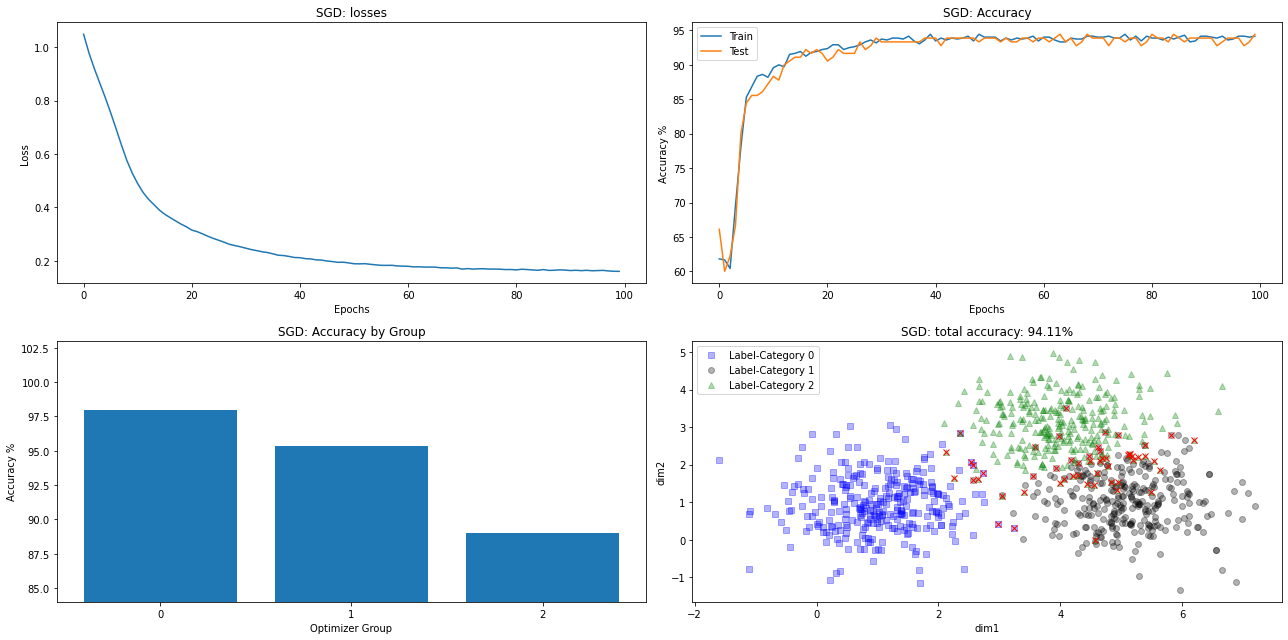

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.95it/s]


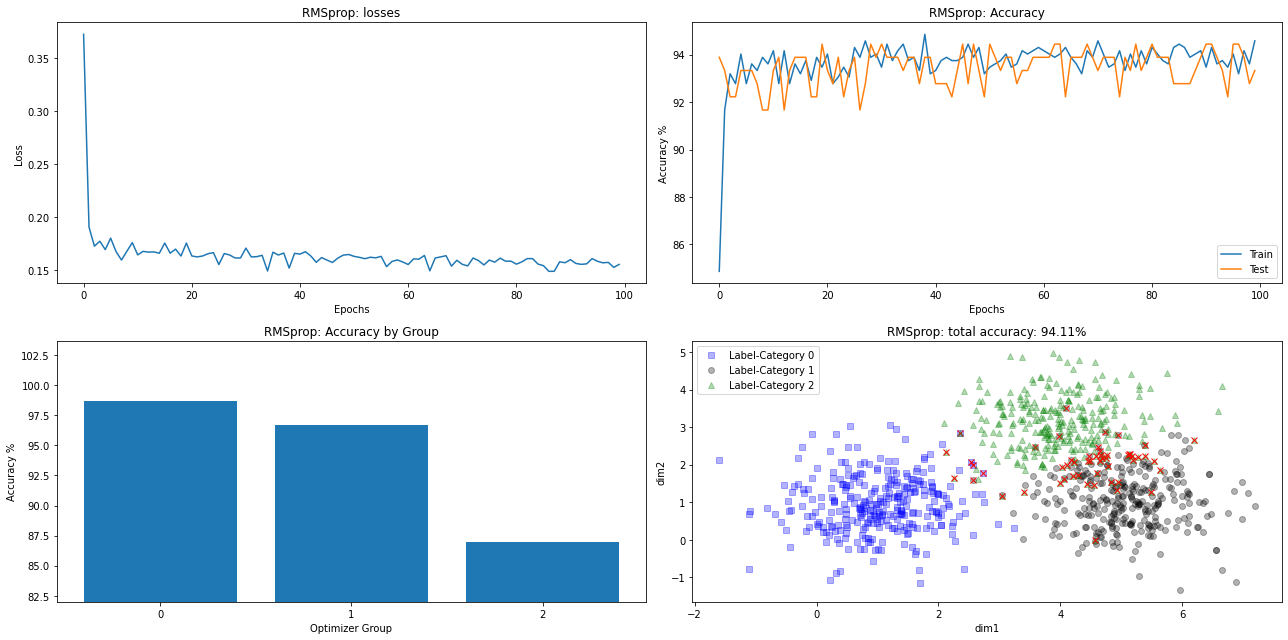

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.40it/s]


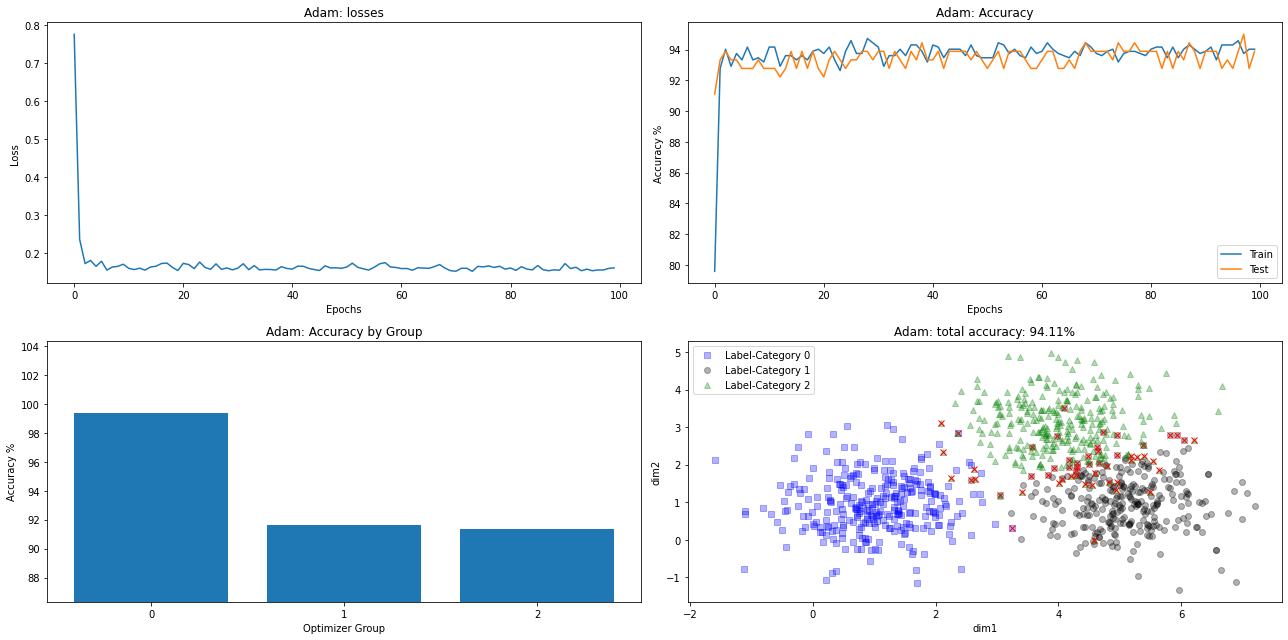

['SGD: Train 94.0%, Test 93.6%',
 'RMSprop: Train 93.8%, Test 93.7%',
 'Adam: Train 94.1%, Test 93.6%']

In [10]:
## Run all 3 Optimizer trainings

performance = []

for optim in ["SGD", "RMSprop", "Adam"]:
    trainAcc,testAcc,losses,model = trainModel(0.01,optim, 100)
    plotResults(optim)
    
    train = np.mean(trainAcc[-10:])
    test = np.mean(testAcc[-10:])
    
    performance.append(f"{optim}: Train {train:.1f}%, Test {test:.1f}%")
    
performance

### Parametric Experiment

In [11]:
n=100 #epochs
learningRates = np.logspace(np.log10(.0001), np.log10(.1),20)
optimTypes = ["SGD", "RMSprop", "Adam"]
finalPerformance = np.zeros((len(learningRates), len(optimTypes)))

for idx_o, opto in enumerate(optimTypes):
    for idx_l, lr in enumerate(learningRates):
        trainAcc,testAcc,losses, model = trainModel(lr, opto,n)
        finalPerformance[idx_l, idx_o] = np.mean(testAcc[-10:])  ## Last 10 epoch testAcc mean stored in performance

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.21it/s]


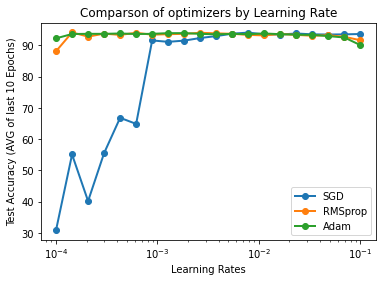

In [12]:
plt.plot(learningRates, finalPerformance, 'o-', linewidth=2)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Learning Rates')
plt.ylabel('Test Accuracy (AVG of last 10 Epochs)')
plt.title('Comparson of optimizers by Learning Rate')
plt.show()

# For SGD the model performance is more dependent on the learning rate.  Learning Rate has strong influence on SGD optimizer
# Adam and RMSProp the learning rate is scaled by the gradient. The effective learnin rate is dynamic, adjusted by optimizer, subject to history of gradient